## 分析A/B测试结果



## 目录
- [简介](#intro)
- [I - 概率](#probability)
- [II - A/B 测试](#ab_test)
- [III - 回归](#regression)


<a id='intro'></a>


<a id='probability'></a>
## I - 概率

**导入并查看数据。

### 一、 导入并查看数据

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` 导入 `ab_data.csv` 数据，并将其存储在 `df` 中。  你可以直接进行以下问题的回答，或者 **做教室里的测试 1** 。

a. 导入数据集，查看前几行数据：

In [2]:
df=pd.read_csv("ab_data.csv")
df.head(3)

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0

b. 查看数据集的行数。

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


 c. 查看数据集中的用户数量（不同的user_id数）。

In [4]:
df['user_id'].nunique()

290584

d. 转化用户的占比。

In [5]:
df.groupby('converted').user_id.count()

converted
0    259241
1     35237
Name: user_id, dtype: int64

In [6]:
ratio=35237/290584
ratio

0.12126269856564711

### 二、处理数据混乱

### e. 请计算数据中 `new_page` 与 `treatment` 不匹配的次数。

提示：在一个合理的实验设计里，控制组(control) 应该对应旧页面(old_page)，实验组(treatment) 对应新页面(new_page)。

In [7]:
df.head()

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1

In [8]:
df.query('group =="control" and landing_page=="new_page" or group =="treatment" and landing_page=="old_page"')

user_id                   timestamp      group landing_page  converted
22       767017  2017-01-12 22:58:14.991443    control     new_page          0
240      733976  2017-01-11 15:11:16.407599    control     new_page          0
308      857184  2017-01-20 07:34:59.832626  treatment     old_page          0
327      686623  2017-01-09 14:26:40.734775  treatment     old_page          0
357      856078  2017-01-12 12:29:30.354835  treatment     old_page          0
...         ...                         ...        ...          ...        ...
294014   813406  2017-01-09 06:25:33.223301  treatment     old_page          0
294200   928506  2017-01-13 21:32:10.491309    control     new_page          0
294252   892498  2017-01-22 01:11:10.463211  treatment     old_page          0
294253   886135  2017-01-06 12:49:20.509403    control     new_page          0
294331   689637  2017-01-13 11:34:28.339532    control     new_page          0

[3893 rows x 5 columns]

In [9]:
df.query('group =="control" and landing_page=="new_page" or group =="treatment" and landing_page=="old_page"').count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. 是否有任何行空缺数值？

In [10]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` 对于 **treatment** 和 **new_page** 不匹配的行或 **control** 与 **old_page** 不匹配的行，我们不能确定该行是否接收到了新页面还是旧页面。如何处理这些行？你可以返回教室里的页面先做 **测试 2** 。  

a. 现在，参照测试2的答案去创建一个符合要求的新数据集。将新 dataframe 存储在 **df2** 中。

我们可以删除“treatment 和 new_page 不匹配的行或 control 与 old_page 不匹配的行”；

也可以提取出匹配的行，组成新的dataframe，即df2；

还可以用drop_duplicates方法，求df和df_unmatched的差集即可:
df2_a=df.append(df_unmatched).drop_duplicates(keep=False),
一次将重复数据全部去除（keep=False）,将重复数据保留一个（keep='first）

In [11]:
# df_unmatched=df.query('group =="control" and landing_page=="new_page" or group =="treatment" and landing_page=="old_page"')
# df_unmatched.head()

In [12]:
## df2 就是满足筛选条件的dataframe
df2=df.query('group =="control" and landing_page=="old_page" or group =="treatment" and landing_page=="new_page"')
df2.head()

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0
3   853541  2017-01-08 18:28:03.143765  treatment     new_page          0
4   864975  2017-01-21 01:52:26.210827    control     old_page          1

In [13]:
# 再次验证df2是否正确
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` 根据 **df2** 来回答以下问题，或者做教室里的 **测试3** 。

a.  **df2** 中的用户数量（不同的 **user_id**) ?

In [14]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 290585 entries, 0 to 294477
Data columns (total 5 columns):
user_id         290585 non-null int64
timestamp       290585 non-null object
group           290585 non-null object
landing_page    290585 non-null object
converted       290585 non-null int64
dtypes: int64(2), object(3)
memory usage: 13.3+ MB


In [15]:
df2['user_id'].nunique()

290584

b.  **df2** 中有一个重复的 **user_id** 。它是什么？

c. 这个重复  **user_id** 的行信息是什么？

In [16]:
df2['user_id'].duplicated().sum()

1

d. 删除一行重复行，但仍然存储 dataframe 为 **df2**。

In [17]:
##  这个重复  **user_id** 的行信息是什么？
df2[df2.duplicated(subset="user_id", keep=False)]

user_id                   timestamp      group landing_page  converted
1899   773192  2017-01-09 05:37:58.781806  treatment     new_page          0
2893   773192  2017-01-14 02:55:59.590927  treatment     new_page          0

In [18]:
df2.drop(1899, inplace=True)
## 不可以这样操作：df2.drop_duplicates(inplace=True)，因为timestamp不唯一

D:\anaconda\lib\site-packages\pandas\core\frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [19]:
df2.shape

(290584, 5)

`4.` 使用优化过的 **df2** 来回答以下问题，或者做 **测试 4**。

a. 用户成功转化的整体概率是多少？（不分旧页面或者新页面）

### 三、概率分析

In [20]:
## 用户转化的总体概率
df2.converted.mean()
## 因为这里的converted只有0，1两个值，所以可以用均值表示转化率

0.11959708724499628

In [21]:
df2.head(3)

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0

#### b. `control` 组用户的转化率是多少？      0.120399
#### c. `treatment` 组用户的转化率是多少？   0.1188

In [22]:
df.groupby('group').converted.mean()
## 也可以用这种方式  df.groupby('group').converted.describe()

group
control      0.120399
treatment    0.118920
Name: converted, dtype: float64

d. 一个用户收到新页面的概率是多少？

In [23]:
df2.head(3)

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0

In [24]:
df2['landing_page'].value_counts(normalize=True)
## 也可以用 df2.query('landing_page=="new_page"').shape[0]/df2.shape[0]
## 也可以用 （df2.landing_page == "new_page").mean()

new_page    0.500062
old_page    0.499938
Name: landing_page, dtype: float64

> 用户收到新页面的概率为0.5001
> 用户收到旧页面的概率为0.5

#### e. 分析到这里，你是否认为有足够的数据支持来证明旧页面或者新页面可以带来更高的转化率？
> 新页面的转化率为0.1188；旧页面的转化率为0.1204，但仅此看来，新页面的转化率比旧页面的转化率略低，但由于两者差距很小，不能仅以此草率得出结论，还需要收集更多的信息得出结论。

<a id='ab_test'></a>
### II - A/B 测试

因为每个事件都对应有一个时间记录（time stamp 时间戳），所以技术上你可以实现每次观察都连续运行假设检验。

然而，问题的难点在于，什么时候停止你的试验：是在发现其中一组的试验效果足够好时立即停止？还是在这样的观察结果又持续发生了一段时间再停止？需要运行多长时间才能确认两个页面没有带来用户转化率的显著差异？

这些问题是 A/B 测试中最难的部分。如果你对下面提到的一些知识点比较生疏，请先回顾课程中的“描述统计学”部分的内容。

`1.` 现在，你需要根据我们提供的数据做出决策：你假设旧页面效果更佳，除非在一类错误在5%以内，新页面被证明更好。基于此，你的零假设和备择假设是什么？ 你可以用文字表述或用 **$p_{old}$** 与 **$p_{new}$** （即，旧页面转化率与新页面转化率）来陈述你的假设。

**在这里给出你的答案。**

#### 零假设：新页面转化率并不比旧页面转化率高   **$p_{new}$**  <= **$p_{old}$**
#### 备择假设：新页面的转化率高   **   $p_{new}$** >  **$p_{old}$** 

`2.` 假定在零假设中，不管是新页面还是旧页面， $p_{new}$ 与 $p_{old}$ 都有相同的转化成功的概率，也就是说，  $p_{new}$ 与 $p_{old}$ 是相等的。此外，我们还假设它们都等于**ab_data.csv** 中的 **转化率(converted)**。  <br>

现在，在新旧页面上执行抽样分布，并计算 **转化(converted)** 差异。记住，每个页面的样本大小要与 **ab_data.csv** 相同。计算零假设中10000次迭代计算的估计值。  <br>

使用下面的单元格提供这个模拟试验的内容。如果不太理解如何进行模拟，不要担心，你可以通过回答下面的问题来理清思路。同时，你可以在教室里的 **测试 5** 里验证你的答案是否正确。<br>

a. 在零假设中，$p_{new}$ **转化率** 是多少？

In [25]:
df2.head(3)

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0

In [26]:
p_new=df2.converted.mean()
p_new

0.11959708724499628

b. 在零假设中， $p_{old}$ **转化率** 是多少？ 

##在零假设中， $p_{old}$ 转化率和 $p_{new}$ 相等 

In [27]:
p_old=df2.converted.mean()
p_old

0.11959708724499628

c.  $n_{new}$ 是多少？

d.  $n_{old}$?是多少？

In [28]:
df2['landing_page'].value_counts()

new_page    145310
old_page    145274
Name: landing_page, dtype: int64

In [29]:
n_new = df2[df2['group'] == 'treatment'].shape[0]
n_old = df2[df2['group'] == 'control'].shape[0]
print(n_new)
print(n_old)

145310
145274


e. 在零假设中，使用 $p_{new}$ （新页面的转化率）模拟 $n_{new}$ 个新页面的转化，并将这些 $n_{new}$ 个 1 和 0 存储在 **new_page_converted** 中。(提示：可以使用  [numpy.random.choice](https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.choice.html)。)

In [30]:
new_page_converted = np.random.choice([1, 0], size=n_new, p=[p_new, (1-p_new)])
new_page_converted

array([0, 0, 0, ..., 0, 1, 0])

In [31]:
new_page_converted.mean()

0.11882182919276031

(array([128044.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  17266.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

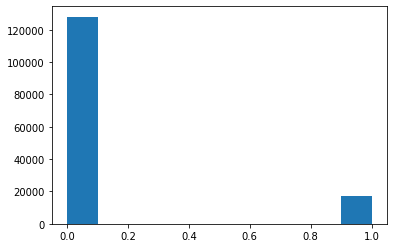

In [32]:
plt.hist(new_page_converted)

f. 在零假设中，使用 $p_{old}$ （旧页面的转化率）模拟 $n_{old}$ 个旧页面的转化，并将这些  $n_{old}$ 个 1 和 0 存储在 **old_page_converted** 中。

In [33]:
old_page_converted = np.random.choice([1, 0], size=n_old, p=[p_old, (1-p_old)])
old_page_converted

array([1, 0, 0, ..., 1, 0, 0])

In [34]:
old_page_converted.mean()

0.11958092982915043

(array([127902.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,  17372.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

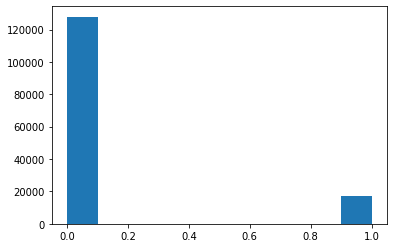

In [35]:
plt.hist(old_page_converted)

g. 根据 e 和 f，计算 $p_{new}$ 和 $p_{old}$ 的差异值（$p_{new}$ - $p_{old}$）。

In [36]:
new_page_converted.mean()-old_page_converted.mean()

-0.0007591006363901198

h. 由于单个数值不能形成分布图形，请参考以上a-g的过程，模拟 10,000 个 $p_{new}$ 与 $p_{old}$ 差异值（$p_{new}$ - $p_{old}$），将这 10,000 个值存储在 **p_diffs** 中。

In [37]:
p_diffs=[]
for k in range(10000): 
    old_page_converted = np.random.choice([1,0],145274,p=[0.8804,0.1196])
    new_page_converted = np.random.choice([1,0],145310,p=[0.8804,0.1196])
    difference = ( new_page_converted.mean() - old_page_converted.mean() )
    p_diffs.append(difference)

In [38]:
np.std(p_diffs)

0.0012163530952429668

(array([   6.,   68.,  384., 1232., 2468., 2832., 1933.,  832.,  213.,
          32.]),
 array([-0.00473988, -0.00384514, -0.0029504 , -0.00205566, -0.00116091,
        -0.00026617,  0.00062857,  0.00152331,  0.00241805,  0.0033128 ,
         0.00420754]),
 <a list of 10 Patch objects>)

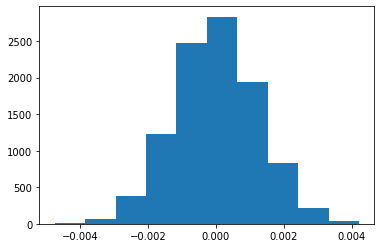

In [39]:
plt.hist(p_diffs)

i. 绘制一个 **p_diffs** 分布图形。图形跟你的预期相符吗？

j.  **p_diffs**列表的数值中，有多少比例的数值会大于 **ab_data.csv** 中观察到的实际**转化率差异** ？

In [40]:
df2.head(3)

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0

In [41]:
observed_mean_treament=df2[df2['group']=='treatment'].converted.mean()-df2[df2['group']=='control'].converted.mean()
observed_mean_treament

-0.0015782389853555567

In [42]:
## 绘制零假设条件下的分布图
null_vals=np.random.normal(0,np.std(p_diffs),10000)

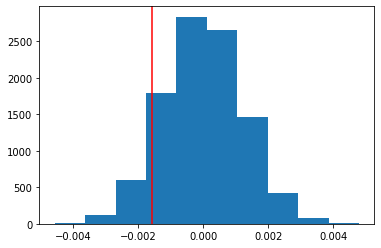

In [43]:
plt.hist(null_vals)
plt.axvline(x=observed_mean_treament,color="red")

In [44]:
(null_vals>observed_mean_treament).mean()

0.9044

k. 用文字解释一下你刚才在 **j.** 中计算出来的结果。在数据研究中，这个值是什么？ 根据这个数值，请判断新旧页面的转化率是否有显著差异。

1、通过计算p值，我们发现p=0.9007，较大,表示不应该抛弃零假设;
2、显著水平，α = 0.05,即冒着5%的概率犯第一类错误风险， p>α 不应拒绝零假设

l. 我们也可以使用一个内置程序 （built-in）来实现类似的结果。使用内置程序可能很容易就能取得结果，但上面的内容仍然很重要，它可以训练你具有正确的数据统计思维。填写下面的内容来计算每个页面的转化次数，以及收到每个页面的用户数。计算新旧页面出现的次数，也就是数据中 `n_old` 与 `n_new` 分别出现的行数。

In [45]:
df2.head(3)

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0

In [46]:
import statsmodels.api as sm

convert_old = df2.query("landing_page=='old_page' and converted==1").shape[0]
convert_new = df2.query("landing_page=='new_page' and converted==1").shape[0]
n_old = df2[df2['group'] == 'control'].shape[0]
n_new = df2[df2['group'] == 'treatment'].shape[0]

In [47]:
print(convert_old)
print(convert_new)
print(n_old)
print(n_new)

17489
17264
145274
145310


m. 现在使用 `stats.proportions_ztest` 来计算你的 z-score (什么是 [z-score](https://www.khanacademy.org/math/statistics-probability/modeling-distributions-of-data/z-scores/a/z-scores-review)) 与 p-value。[这里](http://knowledgetack.com/python/statsmodels/proportions_ztest/) 的资料可以提供额外信息。

In [48]:
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger') 
z_score,p_value

(-1.3109241984234394, 0.9050583127590245)

n. 根据上题算出的 z-score 和 p-value，你认为新旧页面的转化率是否有区别？它们与 **j.** 与 **k.** 问题中的结果一致吗？

**在这里给出你的答案。**

p值仍大于0.05，并且z得分未超过95％置信区间的临界值-这意味着我们仍然不应该拒绝零假设，仍然表明新页面和旧页面之间在统计上没有显着差异

<a id='regression'></a>
### III - 回归分析法之一

`1.` 在最后一部分中，你会看到，你在之前的A / B测试中获得的结果也可以通过执行回归来获取。<br><br>

a. 既然每行的值是转化或不转化，那么在这种情况下，我们应该执行哪种类型的回归？

**在这里给出你的答案。**

因为是预测分类变量，并且只有两个结果“转化”，“不转化”，所以适合逻辑回归

b. 目标是使用 **statsmodels** 来拟合你在 **a.** 中指定的回归模型，以查看用户收到的不同页面是否存在显著的转化差异。但是，首先，你需要为这个截距创建一个列（ 原文：column） ，并为每个用户收到的页面创建一个虚拟变量列。添加一个 **截距** 列，一个 **ab_page** 列，当用户接收 **treatment** 时为1， **control** 时为0。

In [49]:
df2.head(3)

user_id                   timestamp      group landing_page  converted
0   851104  2017-01-21 22:11:48.556739    control     old_page          0
1   804228  2017-01-12 08:01:45.159739    control     old_page          0
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0

In [50]:
df2[['control','ab_page']]=pd.get_dummies(df2['group'])

D:\anaconda\lib\site-packages\pandas\core\frame.py:3494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [51]:
df2.head(3)

user_id                   timestamp      group landing_page  converted  \
0   851104  2017-01-21 22:11:48.556739    control     old_page          0   
1   804228  2017-01-12 08:01:45.159739    control     old_page          0   
2   661590  2017-01-11 16:55:06.154213  treatment     new_page          0   

   control  ab_page  
0        1        0  
1        1        0  
2        0        1

In [52]:
df2['intercept']=1

D:\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.



c. 使用 **statsmodels** 导入你的回归模型。 实例化该模型，并使用你在 **b.** 中创建的2个列来拟合该模型，用来预测一个用户是否会发生转化。

In [53]:
logit_mod=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results=logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 11 Mar 2020   Pseudo R-squ.:               8.077e-06
Time:                        20:46:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

d. 请在下方提供你的模型摘要，并根据需要使用它来回答下面的问题。

e. 与 **ab_page** 关联的 p-值是多少？ 为什么它与你在 **II** 中发现的结果不同？<br><br>  **提示**: 与你的回归模型相关的零假设与备择假设分别是什么？它们如何与 **Part II** 中的零假设和备择假设做比较？

**在这里给出你的答案。**

In [54]:
## 首先对系数ab_page指数化，
1/np.exp(-0.015)

1.015113064615719

**表示每降低一个单位，new_page的转化率是原有的1.05倍**

与 **ab_page** 关联的 p-值是0.19，如果其他变量保持不变，我们用 new_page作为回归变量，与new_page相比，获得new_page的用户转换的可能性为1.015倍

ab_page的p值，与 **II** 中发现的结果不同的原因是因为彼此的假设检验不同。

在**II** 中的零假设：新页面转化率并不比旧页面转化率高  𝑝_𝑛𝑒𝑤  <=  𝑝_𝑜𝑙𝑑 ,备择假设：新页面的转化率高  𝑝_𝑛𝑒𝑤>  𝑝_𝑜𝑙𝑑；

在逻辑回归中，我们的零假设是 𝑝_𝑛𝑒𝑤  ==  𝑝_𝑜𝑙𝑑；备择假设是 p_old != p_new

f. 现在，你一定在考虑其他可能影响用户是否发生转化的因素。讨论为什么考虑将其他因素添加到回归模型中是一个不错的主意。在回归模型中添加附加项有什么弊端吗？

**为什么考虑将其他因素添加到回归模型中是个不错的主意？**

影响新页面，旧页面的受欢迎程度的因素有很多，譬如页面的风格，页面的布局，页面的加载速度，关键词的突出情况等等，这些数据
越具体，越精确，越有助于我们了帮助我们提高模型的可预测性。

**在回归模型中添加附加项的弊端**

1、假如的附加项多，会让模型的训练速度下降；
2、因为不确定附加项，与页面的转化关系到底有多紧密，譬如可能有多重共线性的特征，有冗余的特征，有的特征你认为有关系，但实际与
结果没有关联，反而有可能会影响解释的准确度，混淆结果；
3、添加多的附加项会给模型增加不必要的复杂性，从而难以解释结果。

g. 现在，除了测试不同页面的转化率是否会发生变化之外，还要根据用户居住的国家或地区添加一个 effect 项。你需要导入 **countries.csv** 数据集，并将数据集合并在适当的行上。 [这里](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) 是链接表格的文档。 

这个国家项对转化有影响吗？不要忘记为这些国家的列创建虚拟变量—— **提示: 你将需要为这三个虚拟变量增加两列。** 提供统计输出，并书面回答这个问题。

In [55]:
countries_df = pd.read_csv('countries.csv')
countries_df.head()

user_id country
0   834778      UK
1   928468      US
2   822059      UK
3   711597      UK
4   710616      UK

In [56]:
## 两个表有相同的user_id,可以用merge，join等，concat
df3=pd.concat([countries_df,df2],axis=1,join='inner')
df3.head(3)

user_id country  user_id                   timestamp      group  \
0   834778      UK   851104  2017-01-21 22:11:48.556739    control   
1   928468      US   804228  2017-01-12 08:01:45.159739    control   
2   822059      UK   661590  2017-01-11 16:55:06.154213  treatment   

  landing_page  converted  control  ab_page  intercept  
0     old_page          0        1        0          1  
1     old_page          0        1        0          1  
2     new_page          0        0        1          1

In [57]:
df3['country'].value_counts()

US    200926
UK     71501
CA     14315
Name: country, dtype: int64

In [58]:
##切记这里的 get_dummies 返回的各列是按照字母顺序排序，所以必须是df3[['CA', 'UK', 'US']]
df3[['CA','UK','US']]=pd.get_dummies(df3.country)

In [59]:
df3.head(5)

user_id country  user_id                   timestamp      group  \
0   834778      UK   851104  2017-01-21 22:11:48.556739    control   
1   928468      US   804228  2017-01-12 08:01:45.159739    control   
2   822059      UK   661590  2017-01-11 16:55:06.154213  treatment   
3   711597      UK   853541  2017-01-08 18:28:03.143765  treatment   
4   710616      UK   864975  2017-01-21 01:52:26.210827    control   

  landing_page  converted  control  ab_page  intercept  CA  UK  US  
0     old_page          0        1        0          1   0   1   0  
1     old_page          0        1        0          1   0   0   1  
2     new_page          0        0        1          1   0   1   0  
3     new_page          0        0        1          1   0   1   0  
4     old_page          1        1        0          1   0   1   0

In [60]:
df3.drop('US',axis=1).head(3)

user_id country  user_id                   timestamp      group  \
0   834778      UK   851104  2017-01-21 22:11:48.556739    control   
1   928468      US   804228  2017-01-12 08:01:45.159739    control   
2   822059      UK   661590  2017-01-11 16:55:06.154213  treatment   

  landing_page  converted  control  ab_page  intercept  CA  UK  
0     old_page          0        1        0          1   0   1  
1     old_page          0        1        0          1   0   0  
2     new_page          0        0        1          1   0   1

In [61]:
log_mod = sm.Logit(df3['converted'],df3[['intercept','CA', 'UK','ab_page']])
results3 = log_mod.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.366154
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               286742
Model:                          Logit   Df Residuals:                   286738
Method:                           MLE   Df Model:                            3
Date:                Wed, 11 Mar 2020   Pseudo R-squ.:               1.523e-05
Time:                        20:47:13   Log-Likelihood:            -1.0499e+05
converged:                       True   LL-Null:                   -1.0499e+05
Covariance Type:            nonrobust   LLR p-value:                    0.3620
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9884      0.009   -222.149      0.000      -2.006      -1.971
CA            -0.0260      0.027     -0.968      0.333      -0.079       0.027
UK             0.0062      0.013      0.465      0.642      -0.020       0.032
ab_page       -0.0158      0.012     -1.376      0.169      -0.038       0.007
==============================================================================
"""

In [62]:
# CA，UK ，ab_page
1/np.exp(-0.026),np.exp(0.0062),1/np.exp(-0.0158)

(1.026340948473442, 1.0062192597829778, 1.0159254799902326)

可以看出，在其他变量不变的情况下，来自CA的用户获得的转换的可能性为1.026倍，而来UK获得转换的可能性为1.006倍
1.026与1.006之间的差异较小，所以，国家项对用户的转化变化不大。

logistic回归中的所有系数均未达到低于0.05的p值，这表明着陆页和国家/地区的选择，对转化率没有产生较大的影响， 根据以上分析，我们建议保留旧页面。

h. 虽然你现在已经查看了国家与页面在转化率上的个体性因素，但现在我们要查看页面与国家/地区之间的相互作用，测试其是否会对转化产生重大影响。创建必要的附加列，并拟合一个新的模型。  

提供你的摘要结果，以及根据结果得出的结论。

**提示：页面与国家/地区的相互作用**
```
df3['new_CA'] = df3['new_page'] * df3['CA']
df3['new_UK'] = df3['new_page'] * df3['UK']
```

In [63]:
df3['new_CA'] = df3['ab_page'] * df3['CA']
df3['new_UK'] = df3['ab_page'] * df3['UK']
df3.head(5)

user_id country  user_id                   timestamp      group  \
0   834778      UK   851104  2017-01-21 22:11:48.556739    control   
1   928468      US   804228  2017-01-12 08:01:45.159739    control   
2   822059      UK   661590  2017-01-11 16:55:06.154213  treatment   
3   711597      UK   853541  2017-01-08 18:28:03.143765  treatment   
4   710616      UK   864975  2017-01-21 01:52:26.210827    control   

  landing_page  converted  control  ab_page  intercept  CA  UK  US  new_CA  \
0     old_page          0        1        0          1   0   1   0       0   
1     old_page          0        1        0          1   0   0   1       0   
2     new_page          0        0        1          1   0   1   0       0   
3     new_page          0        0        1          1   0   1   0       0   
4     old_page          1        1        0          1   0   1   0       0   

   new_UK  
0       0  
1       0  
2       1  
3       1  
4       0

In [65]:
log_mod = sm.Logit(df3['converted'],df3[['intercept','ab_page','CA','UK', 'new_CA','new_UK']])
results4 = log_mod.fit()
results4.summary()

Optimization terminated successfully.
         Current function value: 0.366150
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               286742
Model:                          Logit   Df Residuals:                   286736
Method:                           MLE   Df Model:                            5
Date:                Wed, 11 Mar 2020   Pseudo R-squ.:               2.708e-05
Time:                        20:39:45   Log-Likelihood:            -1.0499e+05
converged:                       True   LL-Null:                   -1.0499e+05
Covariance Type:            nonrobust   LLR p-value:                    0.3379
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9849      0.010   -204.831      0.000      -2.004      -1.966
ab_page       -0.0229      0.014     -1.667      0.096      -0.050       0.004
CA            -0.0684      0.039     -1.776      0.076      -0.144       0.007
UK             0.0003      0.019      0.017      0.986      -0.037       0.037
new_CA         0.0839      0.054      1.558      0.119      -0.022       0.189
new_UK         0.0119      0.027      0.444      0.657      -0.041       0.064
==============================================================================
"""

In [64]:
# CA，UK ，ab_page
1/np.exp(-0.0684), np.exp(0.0003),1/np.exp(-0.0229)

(1.070793540242809, 1.0003000450045003, 1.023164218009425)

new_CA,new_UK
可以看出，在其他变量不变的情况下，来自CA的用户获得的转换的可能性为1.071倍，而来UK获得转换的可能性为1.00倍
两者之间的差异较小，所以，页面与国家/地区之间的相互作用，对转化的影响不大。

logistic回归中的所有系数均未达到低于0.05的p值，这表明着陆页和国家/地区的选择，对转化率没有产生较大的影响， 根据以上分析，我们建议保留旧页面。